# TorchVision Object Detection Finetuning for IMPTOX Particles

In the first version of the particule detector, we used Detectron2 with the pretrained maskrcnn_resnet50_fpn architecture. Here, we do the same without the Detectron2 layer in order to be able to test various parameters and have more controle on the training. With Detectron2 we used the dataset in COCO format, however here we use the same dataset converted to masks. 

**Important**: The curated dataset, accessible from [here](https://universe.roboflow.com/uftir-particles/uftir_curated_square/dataset/5), does not allow export with masks. This is an error made early in the project by selecting "Instance segmentation dataset" instead of "Semantic segmentation dataset". This functionnality might be available later but is currently not and thus, some details are lost as COCO annotation simmplify the masks into polygones. This does not seem to impact much the results. 


From Tutorial:  https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

Note: Here we use only torchvision without PyTorch Lightning. A possibly usefull update would be to use Pytorch Lightning as well, however the helper functions provided by torchvision simplify the process enough !



In [2]:
import os
import torch
import torch.nn as nn
import numpy as np
import torchmetrics

# Get the connected components of the mask
from scipy.ndimage import label

import torch.nn.functional as F
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt


import torchvision
from torchvision.transforms import v2 as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.transforms.functional import to_tensor 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator


from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


# If not done, download the files. They contain helper functions from torchvision. 

#os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
#os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
#os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
#--> For coco_utils.py, change line 162 to: ann["segmentation"] = coco_mask.encode(masks[i].cpu().numpy())

#os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
#os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

# Torchvision helper functions

import utils
from engine import train_one_epoch, evaluate


# TBD
# In future versions: add COCO dataset support and pytorch lightning if possible

#import pytorch_lightning as pl
#from pycocotools.coco import COCO
#from pytorch_lightning import LightningDataModule
#from pytorch_lightning.loggers import TensorBoardLogger

# TODO: add tensorboard for performance review

import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()


torch.cuda.empty_cache() 

### Global variables

In [3]:
data_dir_masks = '/mnt/remote/workspaces/thibault.schowing/0_DATA/IMPTOX/00_Dataset/uFTIR_CurSquareSemantic.v1i.png-mask-semantic/train'
model_weights_dir = '/mnt/remote/workspaces/thibault.schowing/0_DATA/IMPTOX/00_Models'

NUM_EPOCH = 20
LEARNING_RATE = 0.0001

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')



## Create the dataset

This code defines a custom dataset class for PyTorch designed to handle annotated filter images with particles. The class `CustomDataset` extends `torch.utils.data.Dataset`, allowing it to be used seamlessly with PyTorch's data loading utilities. Here is a detailed description of the class and its methods:

### `CustomDataset` Class

#### `__init__(self, data_dir, transform=None, resize=(256, 256))`
The constructor initializes the dataset with the following parameters:
- `data_dir` (string): Directory containing all the images and masks.
- `transform` (callable, optional): Optional transform to be applied to both the image and target.
- `resize` (tuple): Size to which all images and masks will be resized. Default is (256, 256).

**Attributes:**
- `self.data_dir`: Stores the directory containing the data.
- `self.transform`: Stores the transform function.
- `self.resize`: Stores the resize dimensions.
- `self.image_files`: Lists all image files (ending with '.jpg') in the data directory.

#### `__len__(self)`
Returns the number of images in the dataset, determined by the length of `self.image_files`.

#### `__getitem__(self, idx)`
Fetches the image and its corresponding masks at the specified index. If the index is a tensor, it is converted to a list.

**Steps:**
1. **Load Image:**
   - Retrieves the image file name and loads the image in RGB mode.
   - Resizes the image to the specified dimensions.
   - Converts the image to a tensor and casts it to `torch.float32`.

2. **Load Masks:**
   - Initializes an empty list for masks.
   - Iterates over files in the data directory to find masks associated with the current image (files ending with `_mask.png`).
   - Loads and resizes each mask to the specified dimensions.
   - Converts masks to numpy arrays and combines them using `np.maximum.reduce`.

3. **Label Masks:**
   - Uses connected component labeling to identify individual objects in the combined mask.
   - Converts the labeled array to a tensor.

4. **Process Masks:**
   - Extracts unique object IDs (excluding the background).
   - Creates binary masks for each object.
   - Computes bounding boxes for each mask, clamping to avoid negative values.
   - Filters out invalid boxes (zero width or height).

5. **Prepare Targets:**
   - Constructs a dictionary for the target data:
     - `boxes`: Bounding boxes of the objects.
     - `masks`: Binary masks.
     - `labels`: Labels for the objects (all set to 1).
     - `image_id`: ID of the image.
     - `area`: Area of each bounding box.
     - `iscrowd`: Crowd flag for each object (all set to 0).

6. **Transform and Return:**
   - Applies optional transforms to the image and target.
   - Converts the image to the specified device.
   - Returns the image and target dictionary.

### Example Usage
To use the `CustomDataset` class, you would typically instantiate it with the directory containing your images and masks, optionally provide a transform, and then use it with a PyTorch DataLoader. This is what is done later in this document. 

```python
from torch.utils.data import DataLoader

dataset = CustomDataset(data_dir='/path/to/data')
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)

for images, targets in dataloader:
    # Training loop code here
```


In [4]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None, resize=(256, 256)):
        """
        Args:
            data_dir (string): Directory with all the images and masks.
            transform (callable, optional): Optional transform to be applied on a sample.
            target_transform (callable, optional): Optional transform to be applied on the target (mask).
            class_mode (string): 'file' for different mask files per class, 'color' for different colors in a single mask.
            color_mapping (dict): Mapping from color to class if class_mode is 'color'.
        """
        self.data_dir = data_dir
        self.transform = transform
        self.resize = resize
        self.image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            

        img_name = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        
        image = image.resize(self.resize, Image.BILINEAR)
        
        image = to_tensor(image).to(torch.float32)

        # Get all masks for the current image (normally only one, but ready if multiple classes are present)
        masks = []
        for f in os.listdir(self.data_dir):
            #print(f"> current file: {f}")
            if f.startswith(self.image_files[idx].replace('.jpg', '')) and f.endswith('_mask.png'):
                
                mask_path = os.path.join(self.data_dir, f)
                mask = Image.open(mask_path).convert('L')
                
                # Resize mask to a fixed size 
                mask = mask.resize((256, 256), Image.NEAREST)
                
                masks.append(np.array(mask))
                
        combined_mask = np.maximum.reduce(masks)
        
        
        # Use connected component labeling to find individual objects
        labeled_array, num_features = label(combined_mask)
        labeled_mask = torch.tensor(labeled_array)
        
        mask = torch.tensor(np.array(labeled_mask, dtype=np.uint8))
        # Add the required information: boxes, labels, image_id, area, iscrowd and masks
        
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        
        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
        #print(f"Masks: {masks}")

        # get bounding box coordinates for each mask. Clamp to avoid negative (invalid) values. 
        boxes = torch.clamp(masks_to_boxes(masks), min=0)
        #print(f"Boxes type: {type(boxes)}")
        
        # We need to filter out boxes that have zero width or height
        valid_boxes = []
        for box in boxes:
            x_min, y_min, x_max, y_max = box
            if (x_max > x_min) and (y_max > y_min):
                valid_boxes.append(box)

        # Convert back to tensor
        boxes = torch.stack(valid_boxes) if valid_boxes else torch.empty((0, 4))

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(image)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks).to(DEVICE)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transform:
            image, target = self.transform(image, target)
        
        img = img.to(DEVICE)
        
        return img, target


## Create the model

In [5]:

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.Resize((256, 256)))  # Resize to 256x256
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms).to(DEVICE)

## Create the data loaders


In [6]:



# our dataset has two classes only - background and particles
num_classes = 2
# use our dataset and defined transformations
dataset = CustomDataset(data_dir = data_dir_masks, transform=get_transform(train=True))
dataset_test = CustomDataset(data_dir = data_dir_masks, transform=get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()

dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

# Create an iterator
data_iter_verif = iter(data_loader_test)


## Test data loaders

images shape: torch.Size([3, 256, 256])
targets shape: torch.Size([7, 256, 256])
First box in a total of 7 boxes in XYXY format: tensor([186.,   0., 188.,   1.])


(-0.5, 255.5, 255.5, -0.5)

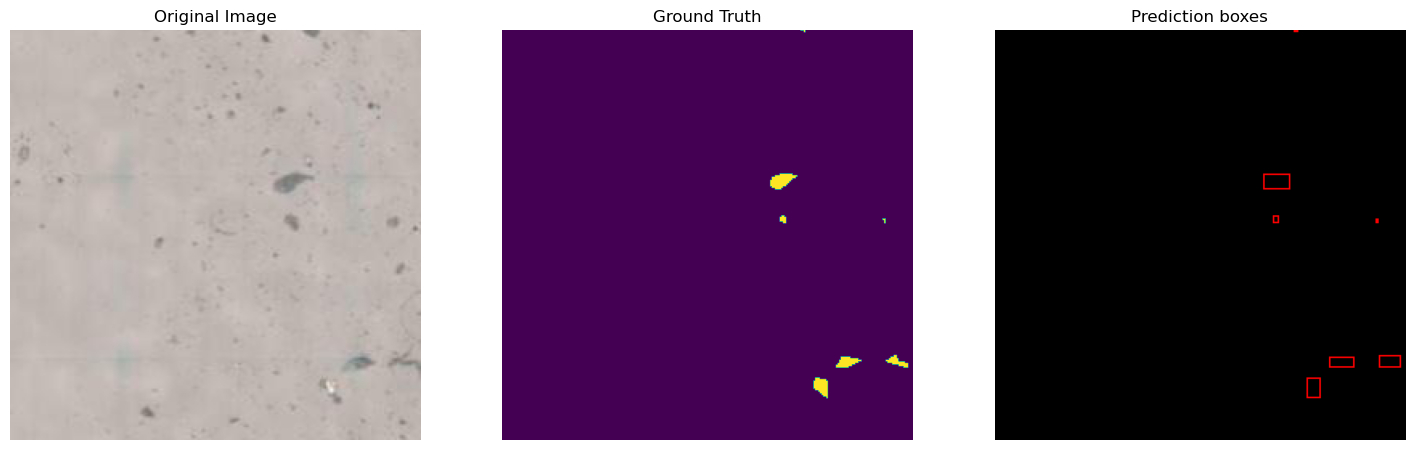

In [7]:


# Get the first batch (which in this case is a single image)
images, targets = next(data_iter_verif)

# Print image shape and target masks shape
print(f"images shape: {images[0].shape}")
print(f"targets shape: {targets[0]['masks'].shape}")

# If you want to access the image and label
image = images[0]
boxes = targets[0]["boxes"]
masks = targets[0]["masks"]

print(f"First box in a total of {len(boxes)} boxes in XYXY format: {boxes[0]}")

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Original image
ax[0].imshow(images[0].cpu().permute(1, 2, 0))
ax[0].set_title("Original Image")
ax[0].axis('off')

# Ground truth
ax[1].imshow(np.maximum.reduce(targets[0]["masks"].cpu()))
ax[1].set_title("Ground Truth")
ax[1].axis('off')



image = image[:3, ...]

output_image = draw_bounding_boxes(image.to(torch.uint8), boxes, colors="red")

#masks = (masks > 0.5).squeeze(1)
#output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

# Predictions
ax[2].imshow(output_image.cpu().permute(1, 2, 0))
ax[2].set_title("Prediction boxes")
ax[2].axis('off')


## Train the model

Here the helper functions of torchvision are used such as "train_one_epoch". 

In [22]:

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir='runs/evaluation')


# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(DEVICE)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]

#optimizer = torch.optim.SGD(
#    params,
#    lr=0.005,
#    momentum=0.9,
#    weight_decay=0.0005
#)

optimizer = torch.optim.Adam(
    params,
    lr=LEARNING_RATE
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)



for epoch in range(NUM_EPOCH):
    #evaluate(model, data_loader_test, device=DEVICE)
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, DEVICE, epoch, print_freq=20)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    # ATTENTION: To correct error, add .cpu() in coco_utils.py at line 162
    coco_evaluator = evaluate(model, data_loader_test, device=DEVICE)
    
    # Accessing bbox evaluation summary
    bbox_eval = coco_evaluator.coco_eval['bbox']
    segm_eval = coco_evaluator.coco_eval.get('segm')
    
    # Summary statistics
    print("Summary statistics bbox:", bbox_eval.stats)
    if segm_eval:
        print("Summary statistics segm:", segm_eval.stats)
    
    # Log progress in TensorBoard
    writer.add_scalar("bbox/AP_50-95", bbox_eval.stats[0], epoch)
    writer.add_scalar("bbox/AP_50", bbox_eval.stats[1], epoch)
    writer.add_scalar("bbox/AP_75", bbox_eval.stats[2], epoch)
    writer.add_scalar("bbox/AP_small", bbox_eval.stats[3], epoch)
    writer.add_scalar("bbox/AP_medium", bbox_eval.stats[4], epoch)
    writer.add_scalar("bbox/AP_large", bbox_eval.stats[5], epoch)
    writer.add_scalar("bbox/AR_50-95", bbox_eval.stats[6], epoch)
    writer.add_scalar("bbox/AR_small", bbox_eval.stats[7], epoch)
    writer.add_scalar("bbox/AR_medium", bbox_eval.stats[8], epoch)
    writer.add_scalar("bbox/AR_large", bbox_eval.stats[9], epoch)
    
    if segm_eval:
        writer.add_scalar("segm/AP_50-95", segm_eval.stats[0], epoch)
        writer.add_scalar("segm/AP_50", segm_eval.stats[1], epoch)
        writer.add_scalar("segm/AP_75", segm_eval.stats[2], epoch)
        writer.add_scalar("segm/AP_small", segm_eval.stats[3], epoch)
        writer.add_scalar("segm/AP_medium", segm_eval.stats[4], epoch)
        writer.add_scalar("segm/AP_large", segm_eval.stats[5], epoch)
        writer.add_scalar("segm/AR_50-95", segm_eval.stats[6], epoch)
        writer.add_scalar("segm/AR_small", segm_eval.stats[7], epoch)
        writer.add_scalar("segm/AR_medium", segm_eval.stats[8], epoch)
        writer.add_scalar("segm/AR_large", segm_eval.stats[9], epoch)

# Close the TensorBoard writer
writer.close()
    
    
    
    

print("That's it! Training finished !")

Epoch: [0]  [  0/165]  eta: 0:03:26  lr: 0.000001  loss: 11.1609 (11.1609)  loss_classifier: 0.7646 (0.7646)  loss_box_reg: 0.2503 (0.2503)  loss_mask: 1.9683 (1.9683)  loss_objectness: 7.2598 (7.2598)  loss_rpn_box_reg: 0.9179 (0.9179)  time: 1.2543  data: 0.1735  max mem: 8317
Epoch: [0]  [ 20/165]  eta: 0:02:51  lr: 0.000013  loss: 7.2934 (7.1959)  loss_classifier: 0.5532 (0.5725)  loss_box_reg: 0.1795 (0.2044)  loss_mask: 1.2414 (1.4090)  loss_objectness: 4.2573 (4.1108)  loss_rpn_box_reg: 0.9221 (0.8991)  time: 1.1827  data: 0.1632  max mem: 8317
Epoch: [0]  [ 40/165]  eta: 0:02:28  lr: 0.000025  loss: 2.4492 (4.8884)  loss_classifier: 0.2813 (0.4277)  loss_box_reg: 0.1797 (0.1967)  loss_mask: 0.6794 (1.0656)  loss_objectness: 0.6506 (2.4242)  loss_rpn_box_reg: 0.6252 (0.7742)  time: 1.1922  data: 0.1535  max mem: 8317
Epoch: [0]  [ 60/165]  eta: 0:02:03  lr: 0.000037  loss: 1.9951 (3.9466)  loss_classifier: 0.2080 (0.3588)  loss_box_reg: 0.1441 (0.1849)  loss_mask: 0.6174 (0.9199

## Tensorboard

On VSCode simply launch the tensorboard from the import section. The training information is located in 'runs/evaluation'. 



### Save the model

In [23]:
print(f"Saving model weights to 'model_weights.pth'...")
torch.save(model.state_dict(), os.path.join(model_weights_dir, 'model_weights.pth'))

Saving model weights to 'model_weights.pth'...


### Load the saved weights

In [8]:
# get the model using our helper function
model = get_model_instance_segmentation(num_classes)
model.load_state_dict(torch.load(os.path.join(model_weights_dir, 'model_weights.pth')))
model.to(DEVICE)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

## Test the model


In [9]:
# Create an iterator
data_iter = iter(data_loader_test)

torch.Size([3, 256, 256])
torch.Size([48, 256, 256])
Pred mask shape: torch.Size([1, 256, 256])
Pred mask content: tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0637, 0.0461, 0.0285],
         [0.0000, 0.0000, 0.0000,  ..., 0.1235, 0.0893, 0.0552],
         [0.0000, 0.0000, 0.0000,  ..., 0.1832, 0.1326, 0.0819],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])


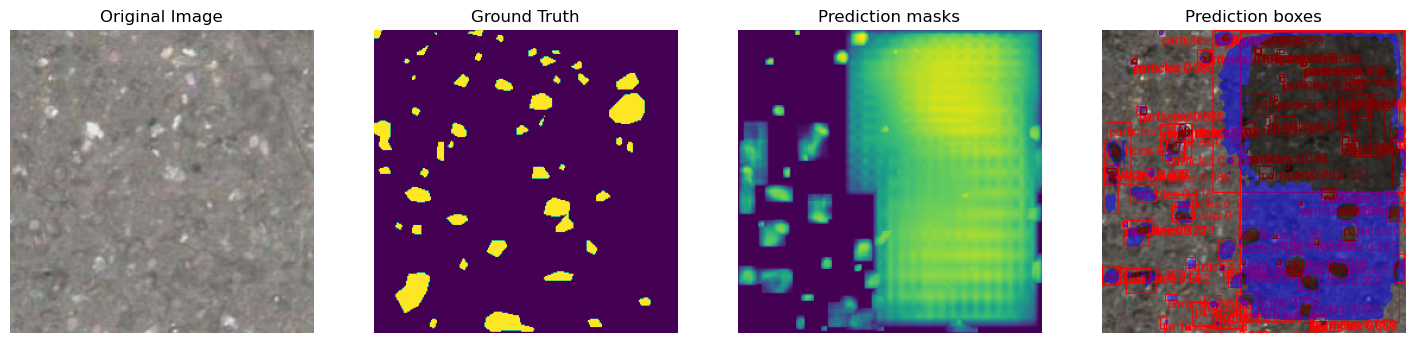

In [18]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torch

# Get the first batch (which in this case is a single image)
images, targets = next(data_iter)

# If you want to access the image and label
image = images[0]
#boxes = targets[0]["boxes"]
masks = targets[0]["masks"]

print(image.shape)
print(masks.shape)

eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(DEVICE)
    predictions = model([x, ])
    pred = predictions[0]


pred_mask = np.maximum.reduce(pred["masks"].cpu())
print(f"Pred mask shape: {pred_mask.shape}")
print(f"Pred mask content: {pred_mask}")

# Plotting
fig, ax = plt.subplots(1, 4, figsize=(18, 6))

# Original image
ax[0].imshow(image.cpu().permute(1, 2, 0))
ax[0].set_title("Original Image")
ax[0].axis('off')

# Ground truth
#ax[1].imshow(masks.cpu().permute(1, 2, 0))
ax[1].imshow(np.maximum.reduce(masks.cpu()))#.permute(1, 2, 0))
ax[1].set_title("Ground Truth")
ax[1].axis('off')

# Predictions
ax[2].imshow(np.maximum.reduce(pred_mask.cpu()))
ax[2].set_title("Prediction masks")
ax[2].axis('off')

# TEST MASK AND BOUNDING BOXES
pred_labels = [f"particles: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]

output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.5).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

# Predictions
ax[3].imshow(output_image.cpu().permute(1, 2, 0))
ax[3].set_title("Prediction boxes")
ax[3].axis('off')

plt.show()


# Results



The Network performs similarly as the one trained with Detectron2 and deployed at the UBFC.

### BIN

In [27]:
# replace the classifier with a new one, that has
# num_classes which is user-defined
#num_classes = 2  # 1 class (particle) + background


# get number of input features for the classifier

#in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one

#model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)



# load a pre-trained model for classification and return
# only the features

#backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features

# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here

#backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios

#anchor_generator = AnchorGenerator(
#    sizes=((32, 64, 128, 256, 512),),
#    aspect_ratios=((0.5, 1.0, 2.0),)
#)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.

#roi_pooler = torchvision.ops.MultiScaleRoIAlign(
#    featmap_names=['0'],
#    output_size=7,
#    sampling_ratio=2
#)

# put the pieces together inside a Faster-RCNN model

#model = FasterRCNN(
#    backbone,
#    num_classes=2,
#    rpn_anchor_generator=anchor_generator,
#    box_roi_pool=roi_pooler
#)